In [1]:
import numpy as np
import random as rand
#import network_equ_xy_energy 
#import network_gen_isotropic 
import openpyxl 
import collections
import timeit
import glob
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import math
from scipy.optimize import fsolve, root
import scipy.optimize as optimize

In [2]:

title_font = {'fontname':'Arial', 'size':'15', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'13'}


In [3]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib as mpl

In [4]:
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation
import tensorflow.keras.backend as K
K.clear_session()
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.2

tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
tf.compat.v1.disable_eager_execution() # need to have this line!!!!



In [58]:
fiber_diameter = 0.1
percent_volume_fraction = 0.3
#scaler_mean = np.array([0.161499,0.45089,3.18844,3.22341]) #0.161499,0.45089,3.18844,3.22341
#scaler_std = np.array([0.0879712,0.281284,0.124943,0.164506])#0.0879712,0.281284,0.124943,0.164506
scaler_mean = np.array([0.1625825,0.45157744,3.18819534,3.22309462]) 
scaler_std = np.array([0.08750812,0.28193681,0.12485259,0.16435753])
#scaler_mean = np.array([0.20201773, 0.63851932, 3.18804961, 3.22289804])
#scaler_std = np.array([0.08507515, 0.20928187, 0.12478928, 0.16425357])
scaleI1_inv = 1/0.12485259
scaleI2_inv = 1/0.16435753
a1 = 0
a2 = 0

def _loss_tensor(y_true, y_pred, x_train):
    
    MAPELoss = 1 * K.mean(abs(100*(y_true - y_pred)/y_true), axis=-1)
    MAELoss = 1 * K.mean(abs(y_true - y_pred), axis=-1)
    MSELoss = 1 * K.mean(K.square(y_true - y_pred), axis=-1)
    
    MAPELoss_psi1 = 1 * K.mean(abs(100*(y_true[:, 0] - y_pred[:, 0])/y_true[:, 0]), axis=-1)
    MSELoss_psi1 = 1 * K.mean(K.square(y_true[:, 0] - y_pred[:, 0]), axis=-1)
    MAELoss_psi1 = 10 * K.mean(abs(y_true[:, 0] - y_pred[:, 0]), axis=-1)
    
    MAPELoss_psi2 = 0 * K.mean(abs(100*(y_true[:, 1] - y_pred[:, 1])/y_true[:, 1]), axis=-1)
    MSELoss_psi2 = 0 * K.mean(K.square(y_true[:, 1] - y_pred[:, 1]), axis=-1)
    MAELoss_psi2 = 100 * K.mean(abs(y_true[:, 1] - y_pred[:, 1]), axis=-1)
    
    with tf.GradientTape() as tape:
        term = K.gradients(model.output, model.input)[0]
    
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    # UPDATED
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    PosDefLoss_1 = K.max([0, -dPsidI1dI1])
    
    PosDefLoss_2 = K.max([0, -(dPsidI1dI1 * dPsidI2dI2 - dPsidI1dI2 *dPsidI2dI1)]) # UPDATED
    SymmLoss = abs(dPsidI1dI2 - dPsidI2dI1)
    
    psi1Loss = MAPELoss_psi1 + MSELoss_psi1 + MAELoss_psi1
    psi2Loss = MAPELoss_psi2 + MSELoss_psi2 + MAELoss_psi2
    #return MAPELoss + MAELoss + MSELoss + a1 * (PosDefLoss_1 + PosDefLoss_2) + a2 * SymmLoss
    #return MSELoss  + a1 * (PosDefLoss_1 + PosDefLoss_2) + a2 * SymmLoss
    #return psi1Loss + psi2Loss + a1 * (PosDefLoss_1 + PosDefLoss_2) + a2 * SymmLoss
    return MSELoss_psi1 + MAPELoss_psi1 + MAELoss_psi1 + MAELoss_psi2 + a1 * (PosDefLoss_1 + PosDefLoss_2) + a2 * SymmLoss

    
def loss_func(x_train):
        def loss(y_true,y_pred):
            return _loss_tensor(y_true, y_pred, x_train)
        return loss

def convexityScore(y_true, y_pred):
    term = K.gradients(y_pred,model.input)[0] 
    
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori

    PosDefLoss_1 = K.max([0, -dPsidI1dI1])
    PosDefLoss_2 = K.max([0, -(dPsidI1dI1 * dPsidI2dI2 - dPsidI1dI2 * dPsidI2dI1)]) #UPDATED
    return PosDefLoss_1 + PosDefLoss_2

def symmetricScore(y_true, y_pred):
    term = K.gradients(y_pred,model.input)[0] 
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = term[2][0],term[3][0],term[2][1],term[3][1] # term[0] and term[1] are the dri rpt 'fiber_diameter'and 'percent_volume_fraction',
    
    #UPDATED
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    
    SymmLoss = abs(dPsidI1dI2 - dPsidI2dI1)
    return SymmLoss

def eval_dPsidI1dI1(y_true, y_pred):
    term = K.gradients(y_pred,model.input)[0] 
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = term[2][0],term[3][0],term[2][1],term[3][1] # term[0] and term[1] are the dri rpt 'fiber_diameter'and 'percent_volume_fraction',
    #print(term)
    #UPDATED
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    
    SymmLoss = abs(dPsidI1dI2 - dPsidI2dI1)
    return dPsidI1dI1

def eval_dPsidI1dI2(y_true, y_pred):
    term = K.gradients(y_pred,model.input)[0] 
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = term[2][0],term[3][0],term[2][1],term[3][1] # term[0] and term[1] are the dri rpt 'fiber_diameter'and 'percent_volume_fraction',
    
    #UPDATED
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    
    SymmLoss = abs(dPsidI1dI2 - dPsidI2dI1)
    return dPsidI1dI2

def eval_dPsidI2dI1(y_true, y_pred):
    term = K.gradients(y_pred,model.input)[0] 
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = term[2][0],term[3][0],term[2][1],term[3][1] # term[0] and term[1] are the dri rpt 'fiber_diameter'and 'percent_volume_fraction',
    
    #UPDATED
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    
    SymmLoss = abs(dPsidI1dI2 - dPsidI2dI1)
    return dPsidI2dI1

def eval_dPsidI2dI2(y_true, y_pred):
    #term = K.gradients(y_pred,model.input)[0] 
    term = K.gradients(y_pred[:,1],model.input)[0] 
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = term[2][0],term[3][0],term[2][1],term[3][1] # term[0] and term[1] are the dri rpt 'fiber_diameter'and 'percent_volume_fraction',
    
    #UPDATED
    #dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    #dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    dPsidI2dI1_ori, dPsidI2dI2_ori = term[2], term[3]
    dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    return dPsidI2dI2


def mae_psi1(y_true, y_pred):
        return abs(y_true[:, 0] - y_pred[:, 0])
    
def mae_psi2(y_true, y_pred):
        return abs(y_true[:, 1] - y_pred[:, 1])

def mse_psi1(y_true, y_pred):
        return (y_true[:, 0] - y_pred[:, 0])**2
    
def mse_psi2(y_true, y_pred):
        return (y_true[:, 1] - y_pred[:, 1])**2

def mape_psi1(y_true, y_pred):
        return abs(100*(y_true[:, 0] - y_pred[:, 0])/y_true[:, 0])
    
def mape_psi2(y_true, y_pred):
        return abs(100*(y_true[:, 1] - y_pred[:, 1])/y_true[:, 1])
    
#model_name = 'convex_model'
#model_name = 'scaledall_0_10000_mix_1110_00100'
model_name = 'scaledall_0_0_mix_1110_00100'
model = tensorflow.keras.models.load_model(model_name, compile=False)
model_loss = loss_func(x_train=model.input)
model.compile(loss = model_loss, optimizer="adam", metrics = [eval_dPsidI1dI1,eval_dPsidI1dI2,eval_dPsidI2dI1,eval_dPsidI2dI2])
 
def evalNN(I1,I2):
    #model_name = 'scaled_105_105_mix_110010_15100'
    #model_name = 'scaledall_0_0_mix_1110_00100'
    #model_name = 'scaledall_100_100_mix_1110_00100'
    
    test_input = np.array([fiber_diameter,percent_volume_fraction,I1,I2])
    rescaled_test_input = ((test_input - scaler_mean)/scaler_std)
    rescaled_test_input  = np.reshape(rescaled_test_input,(1,4))
    pred = model.predict(rescaled_test_input)
    #print(model.input)
    #print(model.output)
    return pred[0] # since pred has the form of [[ 1.298255  -0.8466639]]

def evalNN_derivative(I1,I2):
    #model_name = 'scaled_105_105_mix_110010_15100'
    #model_name = 'scaledall_0_0_mix_1110_00100'
    #model_name = 'scaledall_100_100_mix_1110_00100'
    #model_name = 'convex_model'
    #model = tensorflow.keras.models.load_model(model_name, compile=False)
    test_input = np.array([fiber_diameter,percent_volume_fraction,I1,I2])
    rescaled_test_input = ((test_input - scaler_mean)/scaler_std)
    rescaled_test_input  = np.reshape(rescaled_test_input,(1,4))
    pred = model.predict(rescaled_test_input)
    with tf.GradientTape() as tape:
        term = K.gradients(model.output, model.input)[0]
    dPsidI1dI1_ori, dPsidI1dI2_ori, dPsidI2dI1_ori, dPsidI2dI2_ori = term[2][0],term[3][0],term[2][1],term[3][1]
    dPsidI1dI1, dPsidI1dI2, dPsidI2dI1, dPsidI2dI2 = scaleI1_inv * dPsidI1dI1_ori, scaleI2_inv * dPsidI1dI2_ori, scaleI1_inv * dPsidI2dI1_ori, scaleI2_inv * dPsidI2dI2_ori
    tf.print(dPsidI1dI1)
    return 0

In [24]:
test_input = np.array([fiber_diameter,percent_volume_fraction,3.2,3.2])
rescaled_test_input = ((test_input - scaler_mean)/scaler_std)
rescaled_test_input  = np.reshape(rescaled_test_input,(1,4))
rescaled_test_input = np.vstack([rescaled_test_input,rescaled_test_input,rescaled_test_input,rescaled_test_input,rescaled_test_input])
out = model.evaluate(rescaled_test_input,np.zeros((5,2)),batch_size=20_000)
print(out)

[inf, -1.802027, -1.3688922, 1.71976, 6.2295723]


In [101]:
Model_Gradient_Psi1 = K.function(inputs=[model.input[0],model.input[1],model.input[2],model.input[3]],outputs=K.gradients(model.output[0],model.input))

In [107]:
Model_Gradient_Psi1(inputs=[rescaled_test_input])

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1_11' with dtype float and shape [?,4]
	 [[{{node input_1_11}}]]

In [6]:
## Plot the prediction of the NN over the I1 and I2 space to see if it looks like it increases with I1 and I2
lamx_ls = np.linspace(1,1.25,25)
lamy_ls = np.linspace(1,1.25,25)
Psi1_vec = np.zeros((25**2))
Psi2_vec = np.zeros((25**2))
I1_vec = np.zeros((25**2))
I2_vec = np.zeros((25**2))
for i in range(25):
    lamx = lamx_ls[i]
    for j in range(25): 
        lamy = lamy_ls[j]
        lamz = 1./(lamx*lamy)
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        Psi1,Psi2 = evalNN(I1,I2)
        I1_vec[i*25+j] = I1
        I2_vec[i*25+j] = I2
        Psi1_vec[i*25+j] = Psi1
        Psi2_vec[i*25+j] = Psi2
        

In [42]:
def eval_Psi_ogden(mu,alpha,lamx,lamy,lamz):
    return mu/alpha*(lamx**alpha+lamy**alpha+lamz**alpha-3)

In [59]:
# equibiaxial curve and Psi1 and Psi2 along equibiaxial curve and check if it satisfy convexity 
n_eb = 25
lam_eq_ls = np.linspace(1,1.25,n_eb)
Psi1_eb = np.zeros((n_eb))
Psi2_eb = np.zeros((n_eb))
Psi11_eb = np.zeros((n_eb))
Psi22_eb = np.zeros((n_eb))
Psi12_eb = np.zeros((n_eb))
Psi21_eb = np.zeros((n_eb))
Psi11_eb_num = np.zeros((n_eb))
Psi22_eb_num = np.zeros((n_eb))
Psi12_eb_num = np.zeros((n_eb))
Psi21_eb_num = np.zeros((n_eb))
I1_eb = np.zeros((n_eb))
I2_eb = np.zeros((n_eb))
# checking convexity of Ogden 
Psi1_ogden_equi = np.zeros((n_eb))
Psi2_ogden_equi = np.zeros((n_eb))
Psi_ogden_equi = np.zeros((n_eb))
for i in range(n_eb):
    lamx = lam_eq_ls[i]
    lamy = lam_eq_ls[i]
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    Psi1,Psi2 = evalNN(I1,I2)
    I1_eb[i] = I1
    I2_eb[i] = I2
    Psi1_eb[i] = Psi1
    Psi2_eb[i] = Psi2
    # estimate Hessian numerically 
    eps=1e-5
    I1p = I1+eps
    Psi1p1,Psi2p1 = evalNN(I1p,I2)
    Psi11_eb_num[i] = (Psi1p1 - Psi1)/eps 
    Psi21_eb_num[i] = (Psi2p1 - Psi2)/eps 
    I2p = I2+eps
    Psi1p2,Psi2p2 = evalNN(I1,I2p)
    Psi12_eb_num[i] = (Psi1p2 - Psi1)/eps 
    Psi22_eb_num[i] = (Psi2p2 - Psi2)/eps 
    # Hessian from the DNN 
    test_input = np.array([fiber_diameter,percent_volume_fraction,I1,I2])
    rescaled_test_input = ((test_input - scaler_mean)/scaler_std)
    rescaled_test_input  = np.reshape(rescaled_test_input,(1,4))
    rescaled_test_input = np.vstack([rescaled_test_input,rescaled_test_input,rescaled_test_input,rescaled_test_input,rescaled_test_input])
    out = model.evaluate(rescaled_test_input,np.zeros((5,2)),batch_size=20_000)
    Psi11_eb[i] = out[-4]
    Psi12_eb[i] = out[-3]
    Psi21_eb[i] = out[-2]
    Psi22_eb[i] = out[-1]

 /Users/abuganza/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning:`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [52]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,5))
ax1.plot(lam_eq_ls,Psi1_eb)
ax2.plot(lam_eq_ls,Psi2_eb)

In [67]:
# compare second derivative computed numerically versus DNN output
fig, axs = plt.subplots(2,2,figsize=(10,5))
axs[0,0].plot(lam_eq_ls,Psi11_eb,color='black')
axs[0,0].plot(lam_eq_ls,Psi11_eb_num,color='red')

axs[0,1].plot(lam_eq_ls,Psi12_eb,color='black')
axs[0,1].plot(lam_eq_ls,Psi12_eb_num,color='red')

axs[1,0].plot(lam_eq_ls,Psi21_eb,color='black')
axs[1,0].plot(lam_eq_ls,Psi21_eb_num,color='red')

axs[1,1].plot(lam_eq_ls,Psi22_eb,color='black')
axs[1,1].plot(lam_eq_ls,Psi22_eb_num,color='red')



In [40]:
(Psi11_eb_num*Psi22_eb_num - Psi12_eb_num*Psi21_eb_num)

array([ -6.42245368,  -6.46139142,  -6.47503384,  -6.52448762,
        -6.4494543 ,  -6.29881924,  -6.48213927,  -6.41534825,
        -6.38578967, -10.01382088, -10.09794914, -10.84089263,
        -4.42668124,  -8.2516749 , -15.4875579 , -15.352839  ,
        -1.89800176,  -1.83263182,  -6.84252655,  -6.6273742 ,
         4.29054126,   2.90754087,   2.9444891 ,   1.61094249,
         1.6143531 ])

In [41]:
np.abs((Psi12_eb_num-Psi21_eb_num))

array([0.27418137, 0.3695488 , 0.35762787, 0.34570694, 0.3695488 ,
       0.33378601, 0.34570694, 0.32186508, 0.30994415, 1.25169754,
       1.29938126, 1.88350677, 0.78678131, 3.68356705, 2.21729279,
       2.16960907, 5.11407852, 5.16176224, 4.51803207, 4.55379486,
       2.52723694, 1.04904175, 1.07288361, 0.26226044, 0.25033951])

In [6]:
## check if Ogden interpolated with plane stress gives us a convex potential 
def eval_Psi_ogden(mu,alpha,lamx,lamy,lamz):
    return mu/alpha*(lamx**alpha+lamy**alpha+lamz**alpha-3)

In [7]:
import GPy

In [36]:
lamx_ls = np.linspace(1,1.25,11)
lamy_ls = np.linspace(1,1.25,11)
I1_vec = np.zeros((11**2))
I2_vec = np.zeros((11**2))
X = np.zeros((11**2,2))
Psi_vec = np.zeros((11**2,1))
mu = 0.4985708
alpha = 8.52112645
for i in range(11):
    for j in range(11):
        lamx = lamx_ls[i]
        lamy = lamy_ls[j]
        lamz = (1./(lamx*lamy))
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
        I1_vec[i*11+j] = I1
        I2_vec[i*11+j] = I2
        X[i*11+j,0] = I1
        X[i*11+j,1] = I2
        Psi_vec[i*11+j] = psi

In [44]:

X_mean = np.mean(X, axis=0)
#X_mean = np.zeros((2))
X_std = np.std(X, axis=0)
#X_std = np.ones((2))

X_scaled = (X - X_mean) / X_std
# and regress between X_s and Z_NH
k1 = GPy.kern.RBF(input_dim=2, ARD=True)
try:
    model_O = GPy.models.GPRegression(X_scaled, Psi_vec, k1)
    model_O.optimize()
    Psi, var = model_O.predict(X_scaled)
    #prediction of the gradient of the GP
    #ad_Psi, dvar = model_NH.predictive_gradients((Xp - X_m) / X_s)
    grad_Psi, dvar = model_O.predict_jacobian(X_scaled)
    dPsidI1 = grad_Psi[:,0,0]/X_std[0]
    dPsidI2 = grad_Psi[:,1,0]/X_std[1]
except np.linalg.LinAlgError:
    print('WARNING: numpy.linalg.LinAlgError: not positive definite, even with jitter.')
    pass

In [53]:
n_eb = 25
lam_eq_ls = np.linspace(1,1.25,n_eb)
I1_eb = np.zeros((n_eb))
I2_eb = np.zeros((n_eb))
# checking convexity of Ogden 
Psi1_ogden_equi = np.zeros((n_eb))
Psi2_ogden_equi = np.zeros((n_eb))
Psi_ogden_equi = np.zeros((n_eb))
X_equi = np.zeros((n_eb,2))
for i in range(n_eb):
    lamx = lam_eq_ls[i]
    lamy = lam_eq_ls[i]
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    I1_eb[i] = I1
    I2_eb[i] = I2
    Psi_ogden_equi[i] = psi 
    X_equi[i,0]  = I1
    X_equi[i,1]  = I2

X_equi_scaled = (X_equi - X_mean) / X_std
grad_Psi, dvar = model_O.predict_jacobian(X_equi_scaled)
dPsidI1_equi_ogden = grad_Psi[:,0,0]/X_std[0]
dPsidI2_equi_ogden = grad_Psi[:,1,0]/X_std[1]

eps = 1e-5

X_equi_p1 = np.zeros((n_eb,2))
X_equi_p1[:,0] = X_equi[:,0] + eps
X_equi_p1[:,1] = X_equi[:,1]
X_equi_scaled_p1 = (X_equi_p1 - X_mean) / X_std
grad_Psi_p1, dvar = model_O.predict_jacobian(X_equi_scaled_p1)
dPsidI1_equi_ogden_p1 = grad_Psi_p1[:,0,0]/X_std[0]
dPsidI2_equi_ogden_p1 = grad_Psi_p1[:,1,0]/X_std[1]
X_equi_p2 = np.zeros((n_eb,2))
X_equi_p2[:,0] = X_equi[:,0] 
X_equi_p2[:,1] = X_equi[:,1]+ eps
X_equi_scaled_p2 = (X_equi_p2 - X_mean) / X_std
grad_Psi_p2, dvar = model_O.predict_jacobian(X_equi_scaled_p2)
dPsidI1_equi_ogden_p2 = grad_Psi_p2[:,0,0]/X_std[0]
dPsidI2_equi_ogden_p2 = grad_Psi_p2[:,1,0]/X_std[1]
dPsidI1dI1 = (dPsidI1_equi_ogden_p1-dPsidI1_equi_ogden)/eps
dPsidI1dI2 = (dPsidI1_equi_ogden_p2-dPsidI1_equi_ogden)/eps
dPsidI2dI1 = (dPsidI2_equi_ogden_p1-dPsidI2_equi_ogden)/eps
dPsidI2dI2 = (dPsidI2_equi_ogden_p2-dPsidI2_equi_ogden)/eps

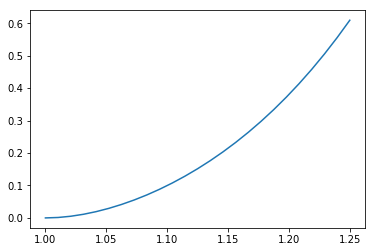

In [47]:
plt.plot(lam_eq_ls,Psi_ogden_equi)

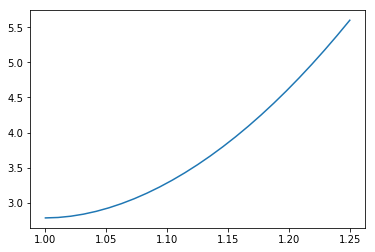

In [48]:
plt.plot(lam_eq_ls,dPsidI1_equi_ogden)

In [49]:
plt.plot(lam_eq_ls,dPsidI2_equi_ogden)

In [70]:
fig, axs = plt.subplots(2,2,figsize=(10,5))
#axs[0,0].plot(lam_eq_ls,Psi11_eb,color='black')
axs[0,0].plot(lam_eq_ls,dPsidI1dI1,color='red')
axs[0,0].set_title('dPsidI1d1')

#axs[0,1].plot(lam_eq_ls,Psi12_eb,color='black')
axs[0,1].plot(lam_eq_ls,dPsidI1dI2,color='red')
axs[0,1].set_title('dPsidI1d2')

#axs[1,0].plot(lam_eq_ls,Psi21_eb,color='black')
axs[1,0].plot(lam_eq_ls,dPsidI2dI1,color='red')
axs[1,0].set_title('dPsidI2d1')

#axs[1,1].plot(lam_eq_ls,Psi22_eb,color='black')
axs[1,1].plot(lam_eq_ls,dPsidI2dI2,color='red')
axs[1,1].set_title('dPsidI2d2')
plt.tight_layout()

In [55]:
(dPsidI2dI2*dPsidI1dI1 - dPsidI1dI2*dPsidI2dI1)

array([-3.06773012, -3.06757637, -3.06729972, -3.06667388, -3.06562124,
       -3.06400912, -3.06168734, -3.05830198, -3.05370295, -3.047668  ,
       -3.03983931, -3.02988432, -3.01755561, -3.00247625, -2.98438595,
       -2.96284257, -2.93763407, -2.90837062, -2.87470483, -2.83632026,
       -2.79308755, -2.74445509, -2.69039886, -2.63065198, -2.56497255])

In [61]:
# So, even Ogden might be non-convex? Maybe this is quite a restrictive assumption
# let's check the other assumption 
n_eb = 25
lam_eq_ls = np.linspace(1,1.25,n_eb)
I1_eb = np.zeros((n_eb))
I2_eb = np.zeros((n_eb))
# checking convexity of Ogden 
Psi1_ogden_equi = np.zeros((n_eb))
Psi2_ogden_equi = np.zeros((n_eb))
Psi_ogden_equi = np.zeros((n_eb))
X_equi = np.zeros((n_eb,2))
for i in range(n_eb):
    lamx = lam_eq_ls[i]
    lamy = lam_eq_ls[i]
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    psi = eval_Psi_ogden(mu,alpha,lamx,lamy,lamz)
    I1_eb[i] = I1
    I2_eb[i] = I2
    Psi_ogden_equi[i] = psi 
    X_equi[i,0]  = I1
    X_equi[i,1]  = I2
    # different check for convexity without second derivatives 
    